# Regressão via processos gaussianos (Gaussian Process Regression - GPR) para estimativas da dinâmica epidêmica da COVID19

 Referências: <br>
 
 [1] https://scikit-learn.org/stable/modules/gaussian_process.html <br>
 [2] https://towardsdatascience.com/quick-start-to-gaussian-process-regression-36d838810319 <br>
 [3] RW2006(1,2,3,4,5,6) Carl Eduard Rasmussen and Christopher K.I. Williams, “Gaussian Processes for Machine Learning”, MIT Press 2006, http://www.gaussianprocess.org/gpml/chapters/RW.pdf<br>




In [15]:
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import signal

### Importa os dados

In [7]:
data = scipy.io.loadmat('cumCasesPB.mat')['cumCasesPB']

trainL = 134 # número de dias  a partir do dia 1 utilizado como conjunto de treinamento
Ndias  = 3    # intervalo de média móvel
futDays = 7  # horizonte de previsão

# calcula média móvel dos dados
data  = np.reshape(data, data.size)
movAvFilter = np.ones(Ndias)/Ndias
movAvFilter = np.reshape(movAvFilter, movAvFilter.size)
data = signal.lfilter(movAvFilter, 1, data)

# escalona valores por milhares
CRdata = data/1000     
DRdata = np.diff(data.transpose())
DRdata = DRdata.transpose()/1000


Text(0.5, 1.0, 'COVID-PB')

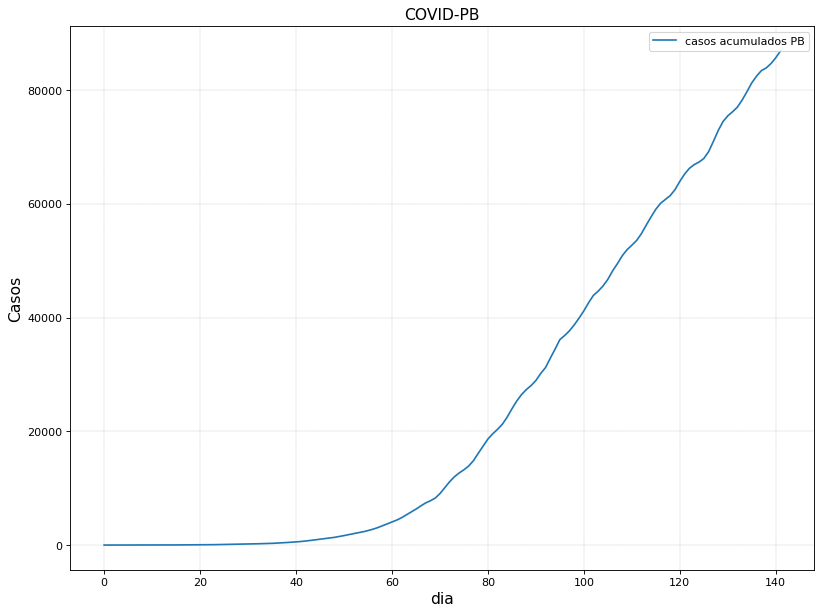

In [8]:
plt.figure(1, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data)
plt.legend(['casos acumulados PB'])
plt.grid(color='k', linestyle='--', linewidth=0.1)
plt.ylabel('Casos', fontsize = 14)
plt.xlabel('dia', fontsize = 14)
plt.title('COVID-PB', fontsize = 14)

### Modelagem GPR para o número de casos acumulados

In [37]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, ExpSineSquared, DotProduct, Matern

# Linha do tempo (entrada do modelo) e dados (saída do modelo)
t = np.linspace(1,len(DRdata)+futDays,len(DRdata)+futDays)
t = t.reshape(len(t),1)
t = np.atleast_2d(t)

CRdata  = np.ravel(CRdata)

# Define intervalo de treinamento
t_tr  = t[0:trainL]
CR_tr = CRdata[0:trainL]

# Define kernel a ser utilizado
kernel = ConstantKernel()* Matern(1.0) + DotProduct()

# Instancia classe GPR
model  = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, alpha = 10, normalize_y=False)

# Treinamento do modelo
model.fit(t_tr, CR_tr)
print("\nLearned kernel: %s" % model.kernel_)
params = model.kernel_.get_params()

# Calcula R2 do modelo:
R2_tr  = model.score(t_tr, CR_tr)
R2     = model.score(t[0:len(CRdata)], CRdata)

# Previsões do modelo
CRpred_, sigma_ = model.predict(t_tr, return_std=True) # previsão no intervalo de treinamento
CRpred, sigma   = model.predict(t, return_std=True)    # previsão para todo o intervalo de dados
   
MSE = np.mean(((CRpred_-CR_tr)*1000)**2)
print("\nMSE: %f" % MSE)
print("\nSTD: %f" % np.sqrt(MSE))
print("\nR2 treinamento: %f" % R2_tr)
print("\nR2 todo intervalo de dados: %f" % R2)


Learned kernel: 34.6**2 * Matern(length_scale=157, nu=1.5) + DotProduct(sigma_0=1.04e-05)

MSE: 105556.053161

STD: 324.893911

R2 treinamento: 0.999834

R2 todo intervalo de dados: 0.999763


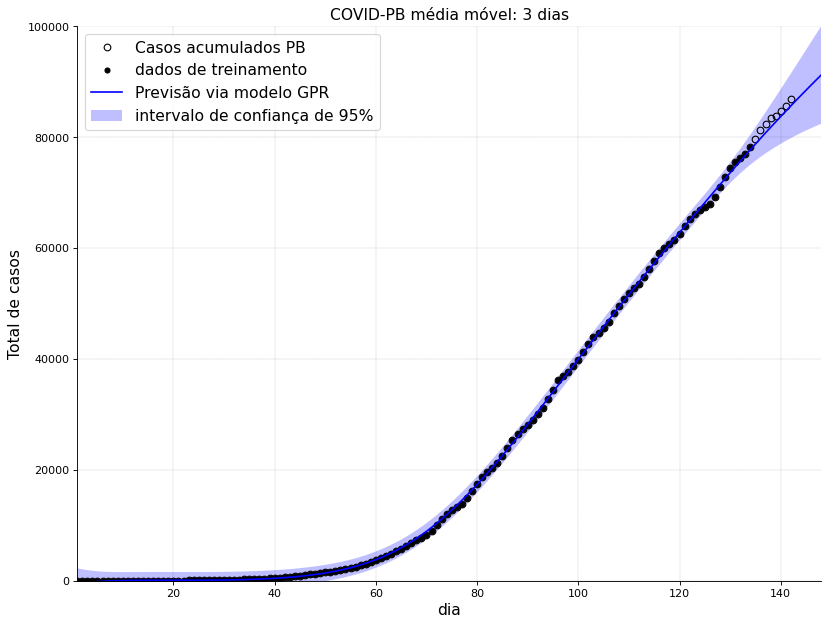

In [38]:
# Plota resultados
plt.figure(1, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
mpl.style.use('default')
plt.plot(t[0:len(DRdata)+1], CRdata*1000, 'ko', markersize=6, mfc='none', linewidth=1, label=r'Casos acumulados PB')
plt.plot(t_tr, CR_tr*1000, 'k.', markersize=9, label='dados de treinamento')
plt.plot(t, CRpred*1000, 'b-', label='Previsão via modelo GPR')
plt.fill(np.concatenate([t, t[::-1]]),
         np.concatenate([CRpred*1000 - 1.9600 * 1000*sigma,
                        (CRpred*1000 + 1.9600 * 1000*sigma)[::-1]]),
         alpha=.25, fc='b', ec='None', label='intervalo de confiança de 95%')
plt.legend(loc='upper left', fontsize = 14)
plt.ylim(0, 100e3)
plt.xlim(1, np.size(t))
plt.grid(color='k', linestyle='--', linewidth=0.1)
plt.ylabel('Total de casos', fontsize = 14)
plt.xlabel('dia', fontsize = 14)
plt.title('COVID-PB média móvel: %d dias' %Ndias, fontsize = 14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

### Modelagem GPR para número de novos casos diários

In [39]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, ExpSineSquared, WhiteKernel, RationalQuadratic


# Linha do tempo (entrada do modelo) e dados (saída do modelo)
t = np.linspace(1,len(DRdata)+futDays,len(DRdata)+futDays)
t = t.reshape(len(t),1)
t = np.atleast_2d(t)

DRdata  = np.ravel(DRdata)

# Define intervalo de treinamento
t_tr  = t[0:trainL]
DR_tr = DRdata[0:trainL]

# Define kernel a ser utilizado
kernel = ConstantKernel()* Matern(1.0, nu=2.5) + ConstantKernel()* Matern(1.0, nu=2.5) * ExpSineSquared(length_scale=1.44, periodicity=7)
# Instancia classe GPR
model  = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=150, alpha = 0.1, normalize_y=False)

# Treinamento do modelo
model.fit(t_tr, DR_tr)
print("\nParâmetros do kernel após treinamento: %s" % model.kernel_)
params = model.kernel_.get_params()

# Calcula R2 do modelo:
R2_tr  = model.score(t_tr, DR_tr)
R2     = model.score(t[0:len(DRdata)], DRdata)

# Previsões do modelo
DRpred_, sigma_ = model.predict(t_tr, return_std=True) # previsão no intervalo de treinamento
DRpred, sigma   = model.predict(t, return_std=True)    # previsão para todo o intervalo de dados

MSE = np.mean(((DRpred_-DR_tr)*1000)**2)
print("\nMSE treinamento: %f" % MSE)
print("\nSTD treinamento: %f" % np.sqrt(MSE))
print("\nR2 treinamento: %f" % R2_tr)
print("\nR2 todo intervalo de dados: %f" % R2)


Parâmetros do kernel após treinamento: 0.00316**2 * Matern(length_scale=0.000245, nu=2.5) + 0.861**2 * Matern(length_scale=69.4, nu=2.5) * ExpSineSquared(length_scale=4.85, periodicity=0.0115)

MSE treinamento: 17107.464342

STD treinamento: 130.795506

R2 treinamento: 0.943995

R2 todo intervalo de dados: 0.943796


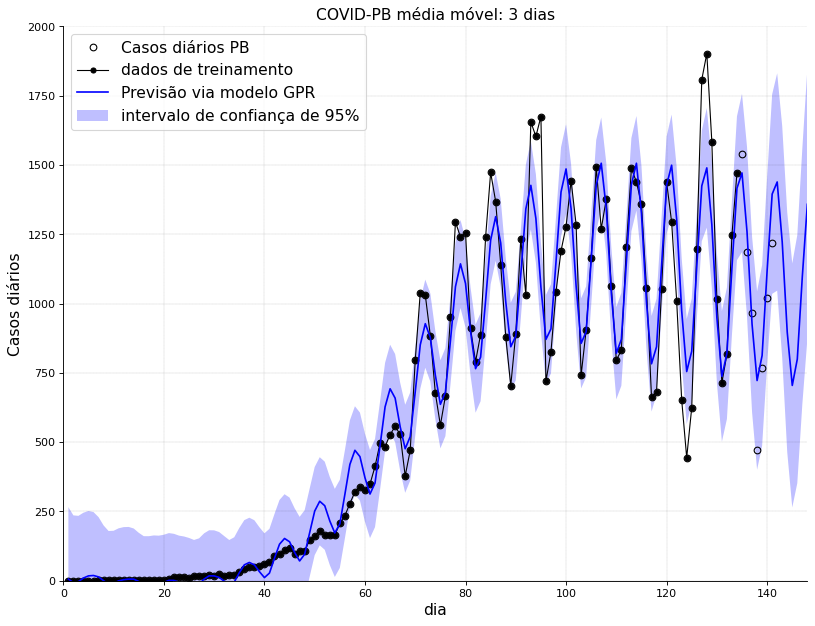

In [41]:
# Plota resultados
plt.figure(1, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t[0:len(DRdata)], DRdata*1000, 'ko', markersize=6, mfc='none', linewidth=1, label=r'Casos diários PB')
plt.plot(t_tr, DR_tr*1000, 'k.-', markersize=9, linewidth=1, label='dados de treinamento')
plt.plot(t, DRpred*1000, 'b-', label='Previsão via modelo GPR')
plt.fill(np.concatenate([t, t[::-1]]),
         np.concatenate([DRpred*1000 - 1.9600 * 1000*sigma,
                        (DRpred*1000 + 1.9600 * 1000*sigma)[::-1]]),
         alpha=.25, fc='b', ec='None', label='intervalo de confiança de 95%')
plt.xlabel('$t$')
plt.ylabel('$Número de casos diários$')
plt.legend(loc='upper left', fontsize = 14)
plt.ylim(0, 2e3)
plt.xlim(0, np.size(t))
plt.grid(color='k', linestyle='--', linewidth=0.1)
plt.ylabel('Casos diários', fontsize = 14)
plt.xlabel('dia', fontsize = 14)
plt.title('COVID-PB média móvel: %d dias' %Ndias, fontsize = 14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)